
# Classification de Scènes Naturelles — Intel Image Classification

Ce notebook couvre **tout le pipeline** : préparation des données, entraînement d'un **CNN de base**, évaluation (métriques + matrice de confusion), **Grad‑CAM**, puis **Transfer Learning** (MobileNetV2) avec fine‑tuning.

> **Dataset** : *Intel Image Classification* (6 classes: `buildings, forest, glacier, mountain, sea, street`).  


In [ ]:

# === 0) Setup
import os, sys, math, itertools, random, pathlib
import numpy as np
import matplotlib.pyplot as plt
import os, glob, math
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

from sklearn.metrics import confusion_matrix, classification_report

print("TensorFlow:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)


TensorFlow: 2.18.1
GPU available: False


In [ ]:
# === 1) Configuration & chemins
BASE_DIR = r"C:\Users\LENOVO\Desktop\deeplearning_project\data"
TRAIN_DIR = os.path.join(BASE_DIR, "seg_train", "seg_train")
VAL_DIR   = os.path.join(BASE_DIR, "seg_test", "seg_test")   # le 'test' de Kaggle = validation
# NOTE: seg_pred est non étiqueté → on ne l'utilise pas pour l'évaluation

IMG_SIZE   = (150, 150)
BATCH_SIZE = 32
SEED       = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels="inferred", label_mode="categorical",
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED, shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR, labels="inferred", label_mode="categorical",
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED, shuffle=False
)

# On évaluera sur val_ds
eval_ds = val_ds
class_names = train_ds.class_names
num_classes = len(class_names)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


Ordre des classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


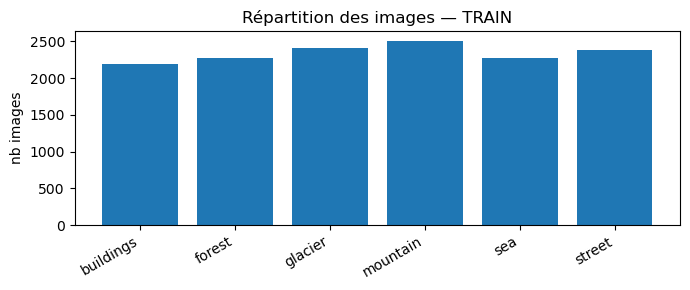

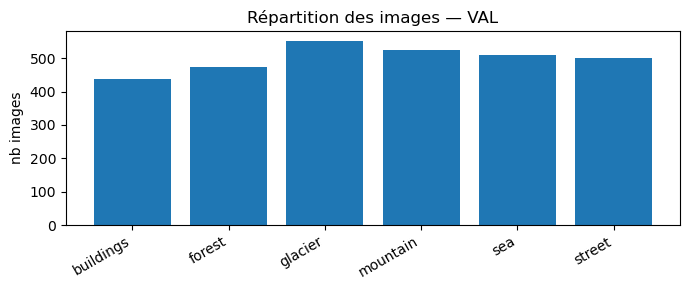

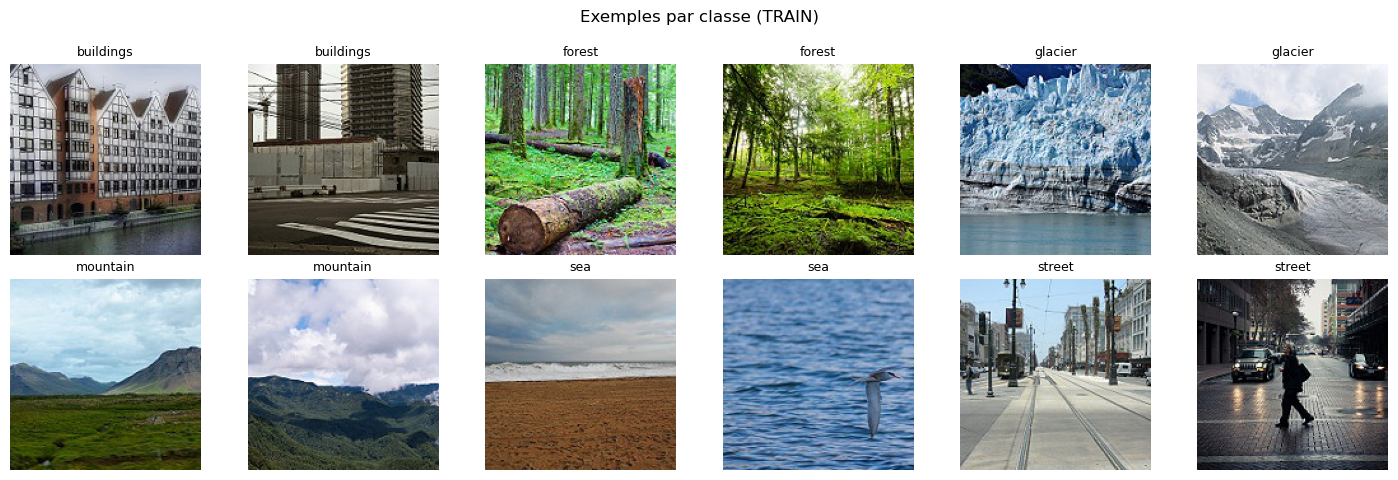

Nb images scannées: 1800
Width mean/std : 150.0 / 0.0
Height mean/std: 149.9 / 2.0


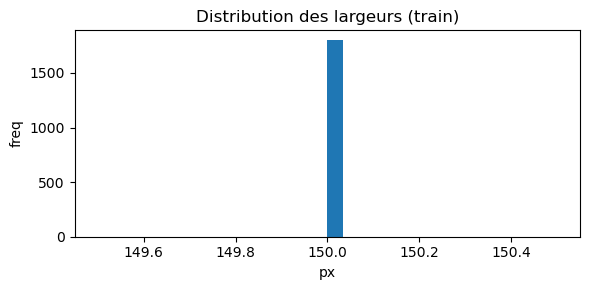

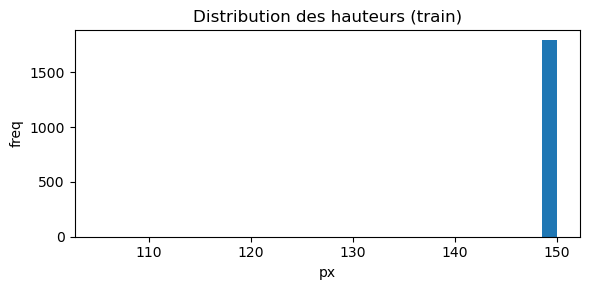

Images corrompues détectées (TRAIN): 0


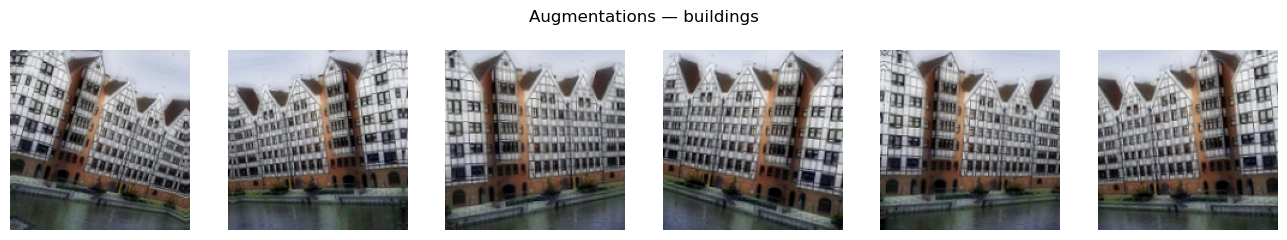

In [ ]:
# === EDA (exploration rapide) 
import pathlib, random, itertools, collections
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import os

# — Verrouiller le mapping des classes (important pour l’inférence)
print("Ordre des classes:", class_names)   # doit être alphabétique
with open("class_names.json","w", encoding="utf-8") as f:
    json.dump(class_names, f)

# — Comptage d’images par split et par classe
def count_by_class(folder, class_names):
    counts = {}
    for c in class_names:
        p = pathlib.Path(folder) / c
        counts[c] = len(list(p.glob("*.*"))) if p.exists() else 0
    return counts

train_counts = count_by_class(TRAIN_DIR, class_names)
val_counts   = count_by_class(VAL_DIR,   class_names)

def plot_bar(d, title):
    cls = list(d.keys()); vals = [d[k] for k in cls]
    plt.figure(figsize=(7,3))
    plt.bar(cls, vals)
    plt.title(title); plt.xticks(rotation=30, ha="right"); plt.ylabel("nb images")
    plt.tight_layout(); plt.show()

plot_bar(train_counts, "Répartition des images — TRAIN")
plot_bar(val_counts,   "Répartition des images — VAL")

# — Grille d’exemples (2 images par classe depuis TRAIN)
def sample_images_per_class(folder, class_names, n=2, seed=42):
    random.seed(seed)
    samples = []
    for c in class_names:
        files = list(pathlib.Path(folder, c).glob("*.*"))
        if not files: 
            continue
        picks = random.sample(files, k=min(n, len(files)))
        samples.extend(picks)
    return samples

def show_grid(files, cols=6, title="Aperçu"):
    if not files:
        print("Aucune image à afficher"); return
    rows = int(np.ceil(len(files)/cols))
    plt.figure(figsize=(cols*2.4, rows*2.4))
    for i, fp in enumerate(files, 1):
        ax = plt.subplot(rows, cols, i)
        ax.imshow(Image.open(fp).convert("RGB"))
        ax.set_title(fp.parent.name, fontsize=9)
        ax.axis("off")
    plt.suptitle(title, y=0.99)
    plt.tight_layout(); plt.show()

train_samples = sample_images_per_class(TRAIN_DIR, class_names, n=2)
show_grid(train_samples, cols=6, title="Exemples par classe (TRAIN)")

# — Tailles d’images (échantillon)
def sizes_in(folder, class_names, limit_per_class=300):
    sizes = []
    for c in class_names:
        files = list(pathlib.Path(folder, c).glob("*.*"))[:limit_per_class]
        for fp in files:
            try:
                with Image.open(fp) as im:
                    sizes.append(im.size)  # (width, height)
            except Exception:
                pass
    return np.array(sizes)

sizes = sizes_in(TRAIN_DIR, class_names, limit_per_class=300)
if len(sizes):
    print("Nb images scannées:", len(sizes))
    print("Width mean/std :", round(sizes[:,0].mean(),1), "/", round(sizes[:,0].std(),1))
    print("Height mean/std:", round(sizes[:,1].mean(),1), "/", round(sizes[:,1].std(),1))
    plt.figure(figsize=(6,3)); plt.hist(sizes[:,0], bins=30); 
    plt.title("Distribution des largeurs (train)"); plt.xlabel("px"); plt.ylabel("freq"); plt.tight_layout(); plt.show()
    plt.figure(figsize=(6,3)); plt.hist(sizes[:,1], bins=30);
    plt.title("Distribution des hauteurs (train)"); plt.xlabel("px"); plt.ylabel("freq"); plt.tight_layout(); plt.show()

# — Détection d’images corrompues (optionnel)
def find_broken(folder, class_names):
    broken = []
    for c in class_names:
        for fp in pathlib.Path(folder, c).glob("*.*"):
            try:
                with Image.open(fp) as im:
                    im.verify()
            except Exception:
                broken.append(str(fp))
    return broken

broken = find_broken(TRAIN_DIR, class_names)
print("Images corrompues détectées (TRAIN):", len(broken))
if broken[:5]: print("Exemples:", broken[:5])

#  — Aperçu des augmentations (mêmes IMG_SIZE que l’entraînement)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

def show_augmentations(example_path, n=6):
    img = Image.open(example_path).convert("RGB").resize(IMG_SIZE)
    x = np.array(img, dtype=np.float32)[None, ...]  # (1, h, w, 3)
    plt.figure(figsize=(n*2.2, 2.4))
    for i in range(n):
        aug = data_augmentation(x, training=True)   # force augmentation
        ax = plt.subplot(1, n, i+1)
        ax.imshow(aug[0].numpy().astype("uint8"))
        ax.axis("off")
    plt.suptitle(f"Augmentations — {pathlib.Path(example_path).parent.name}")
    plt.tight_layout(); plt.show()

# Afficher les augmentations sur une image d'entraînement (si dispo)
if train_samples:
    show_augmentations(str(train_samples[0]), n=6)


In [ ]:
# === 2) Optimisations de performance pour tf.data
AUTOTUNE = tf.data.AUTOTUNE
def prefetch(ds):
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = prefetch(train_ds)
val_ds   = prefetch(val_ds)
if has_test and test_ds is not None:
    test_ds  = prefetch(test_ds)


In [ ]:
# === 3) Data augmentation + Normalisation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

# Normalisation [0,1]
normalization = layers.Rescaling(1./255)


In [ ]:
# === 4) CNN de base
def build_baseline(input_shape=(150,150,3), num_classes=6, dropout_rate=0.4):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = normalization(x)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="baseline_cnn")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

baseline = build_baseline(input_shape=IMG_SIZE + (3,), num_classes=num_classes)
baseline.summary()


Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,402,566 (20.61 MB)

 Trainable params: 5,402,566 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.6337 - loss: 0.9560 - val_accuracy: 0.7233 - val_loss: 0.7527 - learning_rate: 0.0010
Epoch 2/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 417s 949ms/step - accuracy: 0.7430 - loss: 0.6990 - val_accuracy: 0.7920 - val_loss: 0.5867 - learning_rate: 0.0010
Epoch 3/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 436s 994ms/step - accuracy: 0.7864 - loss: 0.5985 - val_accuracy: 0.7957 - val_loss: 0.5639 - learning_rate: 0.0010
Epoch 4/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 358s 815ms/step - accuracy: 0.8073 - loss: 0.5294 - val_accuracy: 0.8177 - val_loss: 0.5176 - learning_rate: 0.0010
Epoch 5/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 324s 737ms/step - accuracy: 0.8234 - loss: 0.4944 - val_accuracy: 0.8210 - val_loss: 0.5260 - learning_rate: 0.0010
Epoch 6/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 318s 724ms/step - accuracy: 0.8353 - loss: 0.4552 - val_accuracy: 0.8023 - val_loss: 0.5779 - learning_rate: 0.0010
Epoch 7/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 320s 728ms/step - accuracy:

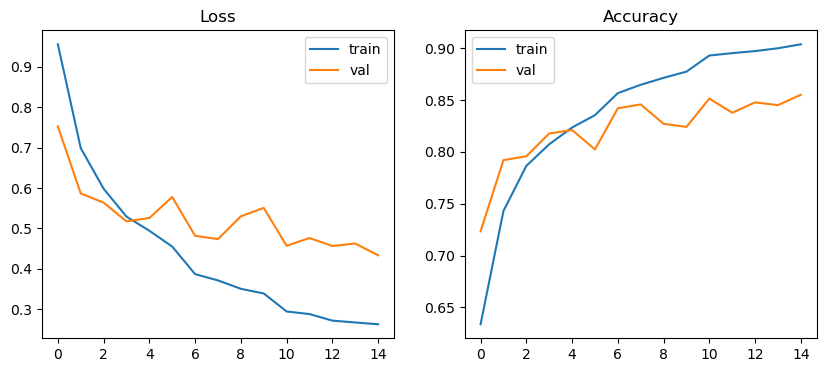

In [8]:

# === 5) Entraînement du modèle de base
EPOCHS = 15

early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
reduce_lr  = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)

history = baseline.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Courbes d'apprentissage
def plot_learning_curves(h):
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].plot(h.history["loss"], label="train")
    ax[0].plot(h.history["val_loss"], label="val")
    ax[0].set_title("Loss")
    ax[0].legend()
    ax[1].plot(h.history["accuracy"], label="train")
    ax[1].plot(h.history["val_accuracy"], label="val")
    ax[1].set_title("Accuracy")
    ax[1].legend()
    plt.show()

plot_learning_curves(history)


Classification report:
              precision    recall  f1-score   support

   buildings      0.837     0.870     0.853       437
      forest      0.934     0.981     0.957       474
     glacier      0.841     0.774     0.806       553
    mountain      0.814     0.785     0.799       525
         sea      0.826     0.869     0.847       510
      street      0.879     0.872     0.876       501

    accuracy                          0.855      3000
   macro avg      0.855     0.858     0.856      3000
weighted avg      0.854     0.855     0.854      3000



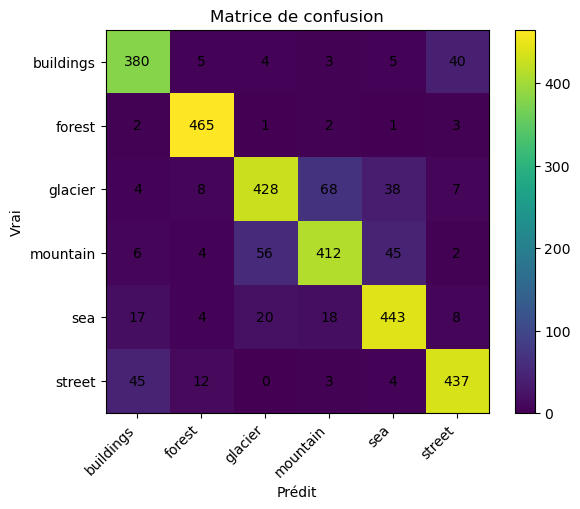

In [9]:

# === 6) Évaluation: rapport + matrice de confusion
def evaluate_model(model, dataset, class_names):
    y_true = []
    y_pred = []
    for batch, labels in dataset:
        preds = model.predict(batch, verbose=0)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(labels.numpy(), axis=1))

    print("Classification report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title("Matrice de confusion")
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center")
    fig.tight_layout()
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.colorbar(im)
    plt.show()

# Utilise test si dispo, sinon validation
eval_ds = test_ds if has_test and test_ds is not None else val_ds
evaluate_model(baseline, eval_ds, class_names)


In [10]:

# === 7) Grad-CAM (explicabilité)
def make_gradcam_heatmap(img_array, model, last_conv_layer_name=None, pred_index=None):
    # Trouver automatiquement la dernière couche conv si non fournie
    if last_conv_layer_name is None:
        last_conv_layer = None
        for layer in reversed(model.layers):
            if isinstance(layer, layers.Conv2D):
                last_conv_layer = layer
                break
        if last_conv_layer is None:
            raise ValueError("Aucune couche Conv2D trouvée dans le modèle.")
        last_conv_layer_name = last_conv_layer.name

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + 1e-8)
    return heatmap.numpy()

def show_gradcam(model, img_path, img_size=IMG_SIZE, alpha=0.35):
    # Charge image
    img = keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_arr = keras.preprocessing.image.img_to_array(img)
    input_arr = np.expand_dims(img_arr, axis=0)
    input_arr = input_arr / 255.0  # normalisation simple

    heatmap = make_gradcam_heatmap(input_arr, model)
    # Affichage côte à côte
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(img)
    ax[0].set_title("Image d'origine")
    ax[0].axis("off")

    # Redimensionne heatmap à la taille de l'image
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], img_size).numpy().squeeze()
    ax[1].imshow(img)
    ax[1].imshow(heatmap_resized, alpha=alpha)
    ax[1].set_title("Grad-CAM")
    ax[1].axis("off")
    plt.show()

# Exemple d'utilisation :
# img_demo = "/chemin/vers/une/image.jpg"
# show_gradcam(baseline, img_demo)


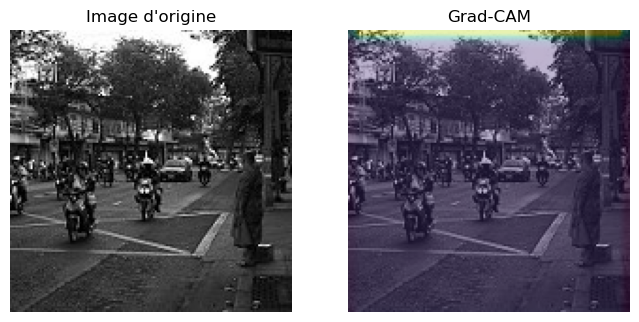

In [39]:
img_demo = "C:\\Users\\LENOVO\\Desktop\\deeplearning_project\\photos\\3.jpg"
show_gradcam(baseline, img_demo)

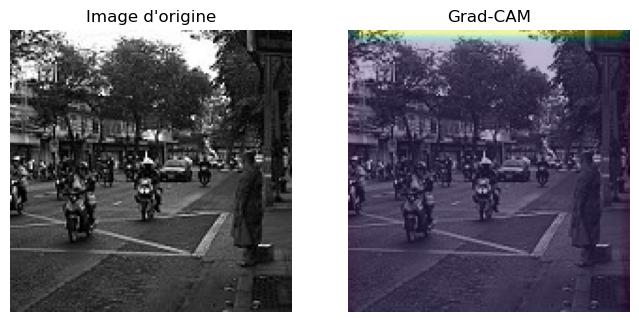

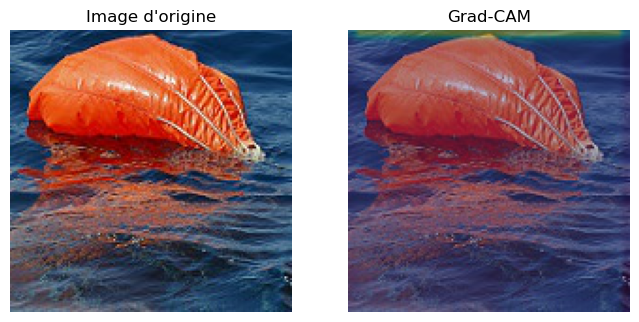

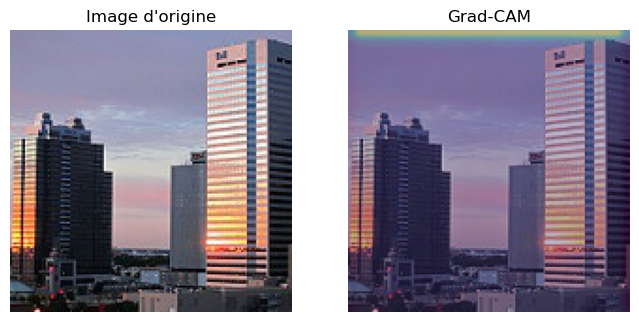

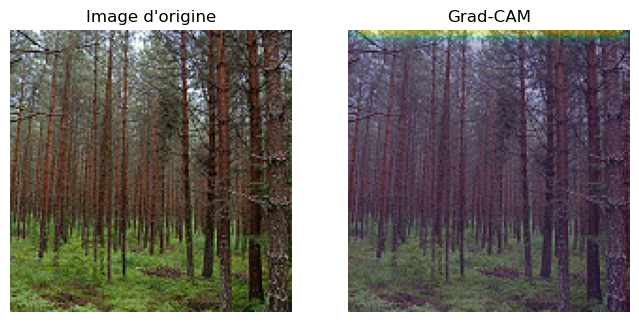

In [42]:
img_list = [
    r"C:\Users\LENOVO\Desktop\deeplearning_project\photos\3.jpg",
    r"C:\Users\LENOVO\Desktop\deeplearning_project\photos\227.jpg",
    r"C:\Users\LENOVO\Desktop\deeplearning_project\photos\5.jpg",
    r"C:\Users\LENOVO\Desktop\deeplearning_project\photos\183.jpg"
]

for img_path in img_list:
    show_gradcam(baseline, img_path)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14012\241338716.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "mobilenetv2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/8
439/439 ━━━━━━━━━━━━━━━━━━━━ 191s 413ms/step - accuracy: 0.8216 - loss: 0.4821 - val_accuracy: 0.8950 - val_loss: 0.2842
Epoch 2/8
439/439 ━━━━━━━━━━━━━━━━━━━━ 181s 413ms/step - accuracy: 0.8781 - loss: 0.3471 - val_accuracy: 0.8930 - val_loss: 0.2924
Epoch 3/8
439/439 ━━━━━━━━━━━━━━━━━━━━ 181s 412ms/step - accuracy: 0.8830 - loss: 0.3277 - val_accuracy: 0.8937 - val_loss: 0.2747
Epoch 4/8
439/439 ━━━━━━━━━━━━━━━━━━━━ 180s 411ms/step - accuracy: 0.8880 - loss: 0.3082 - val_accuracy: 0.8980 - val_loss: 0.2709
Epoch 5/8
439/439 ━━━━━━━━━━━━━━━━━━━━ 181s 413ms/step - accuracy: 0.8881 - loss: 0.3061 - val_accuracy: 0.8913 - val_loss: 0.3005
Epoch 6/8
439/439 ━━━━━━━━━━━━━━━━━━━━ 181s 412ms/step - accuracy: 0.8902 - loss: 0.3008 - val_accuracy: 0.8913 - val_loss: 0.2913
Epoch 7/8
439/439 ━━━━━━━━━━━━━━━━━━━━ 181s 414ms/step - accuracy: 0.8907 - loss: 0.2961 - val_accuracy: 0.9070 - val_loss: 0.2636
Epoch 8/8
439/439 ━━━━━━━━━━━━━━━━━━━━ 193s 439ms/step - accuracy: 0.8946 - loss: 0

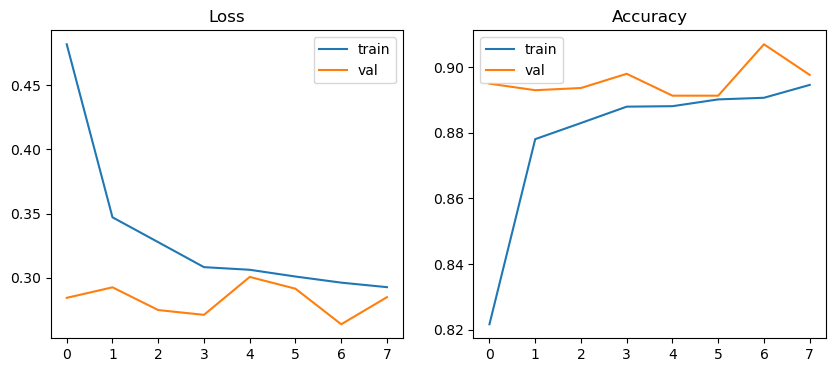

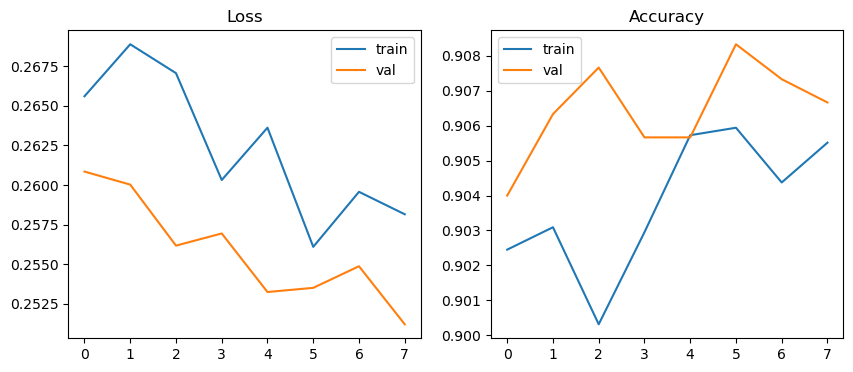

Classification report:
              precision    recall  f1-score   support

   buildings      0.885     0.947     0.915       437
      forest      0.985     0.987     0.986       474
     glacier      0.847     0.832     0.839       553
    mountain      0.853     0.842     0.848       525
         sea      0.931     0.953     0.942       510
      street      0.949     0.898     0.923       501

    accuracy                          0.907      3000
   macro avg      0.908     0.910     0.909      3000
weighted avg      0.907     0.907     0.906      3000



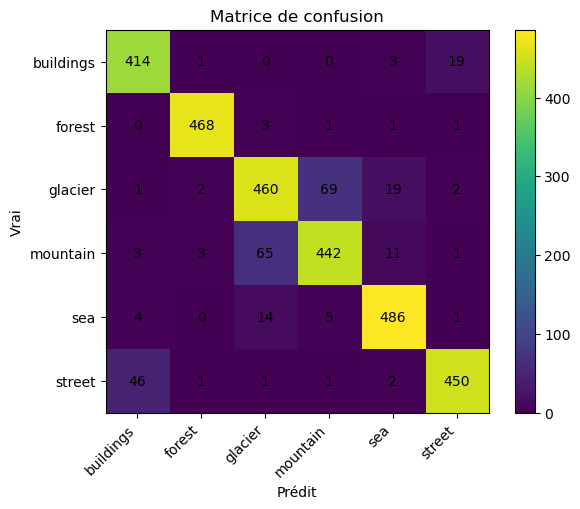

In [11]:

# === 8) Transfer Learning (MobileNetV2)
def build_transfer_model(input_shape=(150,150,3), num_classes=6, base_trainable=False):
    base = tf.keras.applications.MobileNetV2(
        input_shape=input_shape, include_top=False, weights="imagenet"
    )
    base.trainable = base_trainable  # d'abord False (feature extractor)

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)  # normalisation MobileNetV2
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="mobilenetv2_transfer")

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

transfer = build_transfer_model(input_shape=IMG_SIZE + (3,), num_classes=num_classes, base_trainable=False)
transfer.summary()

# Entraînement tête de classification
history_tl = transfer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=[callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
    verbose=1
)

# Fine-tuning (débloquer une partie du backbone)
transfer.get_layer(index=2)  # no-op, juste pour éviter une cellule vide
transfer.trainable = True
# On peut "geler" les premières couches pour stabilité
for layer in transfer.layers[:-20]:
    layer.trainable = False

transfer.compile(optimizer=keras.optimizers.Adam(1e-4),
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

history_ft = transfer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=[callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
    verbose=1
)

plot_learning_curves(history_tl)
plot_learning_curves(history_ft)

# Évaluation finale
evaluate_model(transfer, eval_ds, class_names)


In [27]:
def load_and_prep(img_path, img_size=(224,224)):
    img = image.load_img(img_path, target_size=img_size)
    arr = image.img_to_array(img)
    arr = preprocess_fn(arr)               # <<< le même prétraitement que TRAIN
    arr = np.expand_dims(arr, axis=0)
    return arr

def predict_path(model, path, class_names, img_size=(224,224), topk=3):
    # accepte fichier ou dossier
    if os.path.isdir(path):
        files = []
        for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.webp"):
            files += glob.glob(os.path.join(path, ext))
        if not files:
            print("Aucune image trouvée dans le dossier.")
            return
    else:
        files = [path]

    for fp in files:
        x = load_and_prep(fp, img_size)
        pred = model.predict(x, verbose=0)[0]
        # top-k lisible
        idxs = np.argsort(pred)[::-1][:topk]
        print(os.path.basename(fp), "→",
              ", ".join([f"{class_names[i]}: {pred[i]:.2f}" for i in idxs]))


In [29]:
# 1) même preprocess_fn que TRAIN (ici: rien à refaire car c’est dans le modèle)
preprocess_fn = lambda x: x   # pas de /255, pas de preprocess_input ici

# 2) s’assurer d’avoir les mêmes classes que pendant le training
# (tu as déjà: class_names = train_ds.class_names)
# sinon, recharge depuis un json si tu l’as sauvegardé

# 3) tester sur UNE image (IMG_SIZE = 150,150 comme à l’entraînement)
predict_path(
    model=transfer,
    path=r"C:\Users\LENOVO\Desktop\deeplearning_project\photos\3.jpg",
    class_names=class_names,
    img_size=(150, 150)   # important !
)


3.jpg → street: 1.00, buildings: 0.00, forest: 0.00


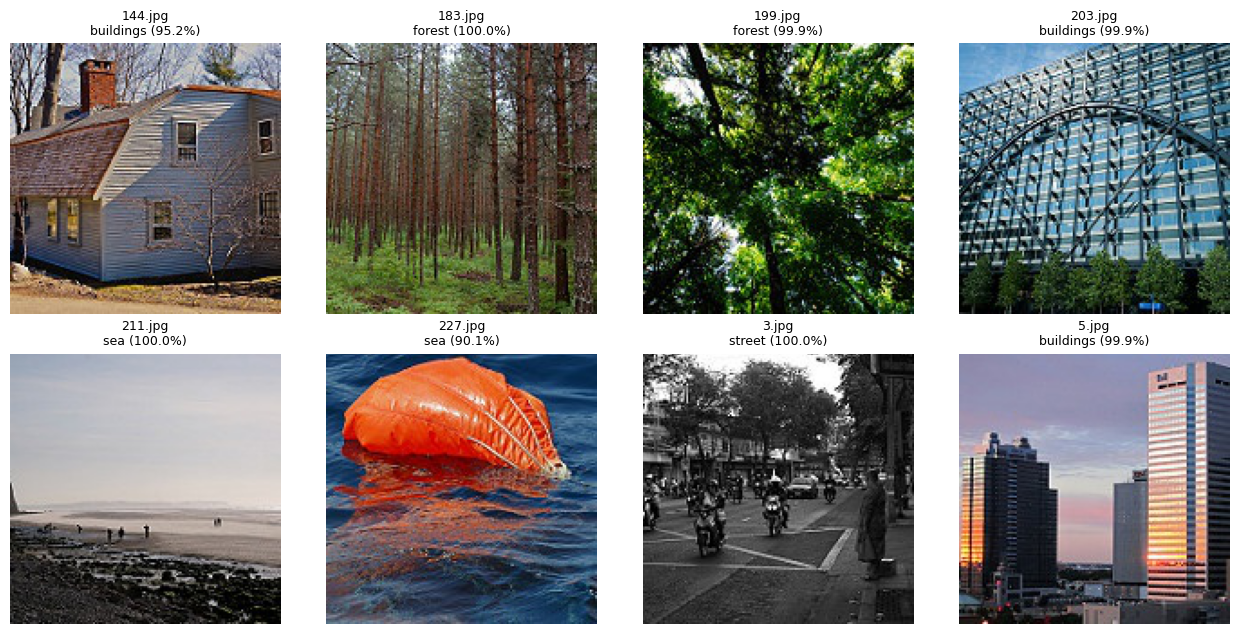

✅ Résultats enregistrés dans c:\Users\LENOVO\Desktop\deeplearning_project\preds_photos.csv


In [43]:
def predict_folder_and_show(model, folder, class_names, img_size=(150,150),
                            cols=4, limit=None, topk=3, csv_path="predictions.csv"):
    # Récupérer les fichiers image
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp")
    files = []
    for e in exts:
        files += glob.glob(os.path.join(folder, e))
    files.sort()
    if not files:
        print("Aucune image trouvée dans le dossier.")
        return
    if limit:
        files = files[:limit]

    # Prédictions + collecte des résultats
    rows = math.ceil(len(files) / cols)
    plt.figure(figsize=(cols*3.2, rows*3.2))
    results = []

    for k, fp in enumerate(files):
        # Préparation (pas de preprocess externe : déjà dans le modèle)
        img = image.load_img(fp, target_size=img_size)
        arr = image.img_to_array(img)
        arr = np.expand_dims(arr, axis=0)

        probs = model.predict(arr, verbose=0)[0]
        idxs = np.argsort(probs)[::-1][:topk]
        top1 = int(idxs[0])

        # Sauvegarde résultat (pour CSV)
        row = {
            "file": fp,
            "pred_top1": class_names[top1],
            "conf_top1": float(probs[top1])
        }
        # Ajouter le top-k en colonnes lisibles
        for rank, i in enumerate(idxs, 1):
            row[f"top{rank}_class"] = class_names[int(i)]
            row[f"top{rank}_prob"]  = float(probs[int(i)])
        results.append(row)

        # Affichage grille
        ax = plt.subplot(rows, cols, k+1)
        ax.imshow(image.load_img(fp))  # image originale
        ax.axis("off")
        ax.set_title(f"{os.path.basename(fp)}\n{class_names[top1]} ({probs[top1]:.1%})", fontsize=9)

    plt.tight_layout()
    plt.show()

    # Export CSV
    df = pd.DataFrame(results)
    df.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"✅ Résultats enregistrés dans {os.path.abspath(csv_path)}")
    return df  # pratique si tu veux l’afficher ensuite

# Exemple d’appel (dossier)
_ = predict_folder_and_show(
    transfer,
    r"C:\Users\LENOVO\Desktop\deeplearning_project\photos",
    class_names,
    img_size=(150,150),
    cols=4,         # nombre de colonnes dans la grille
    limit=None,     # ou un entier pour limiter le nb d’images affichées
    topk=3,
    csv_path="preds_photos.csv"
)
